# Instrument Pricing Analytics - Zero Coupon Curves

In one of my earlier articles on <a href="https://developers.refinitiv.com/en/article-catalog/article/instrument-pricing-analytics-volatility-surfaces-and-curves" target="_blank">Instrument Pricing Analytics - Volatility Surfaces and Curves</a>, I promised I would deliver a follow up article on Zero Coupon Curves - another of the related IPA content sets.

Zero Coupon Curves, like other pricing data (Volatility Surfaces, Inflation Curves), are used to model risk factors and can be used to power risk management or valuation systems.

As with the previous article I think the best way to highlight this content is via some code and a few graphs - so let me dive straight into the code....


#### Initialisation

First thing I need to do is import my libraries and then run my scripts to define my helper functions. 
As you will note I am importing the Refinitiv Data Platform library which will be my main interface to the Platform - as well as few commonly used Python libraries.


In [1]:
import json
#import logging
#logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.DEBUG)
import refinitiv.dataplatform as rdp
import configparser as cp
from IPython.display import HTML
import matplotlib.pyplot as plt
import pandas as pd

%run "plotting_helper.ipynb"

As the name would suggest, the `plotting_helper` contains the full plotting code.  I won't share any of the plotting code snippets in this article - please refer to the actual file on GitHub (see link in right hand panel).

### Connect to the Refinitiv Data Platform
I fetch my credentials from a configuration file and use them to open a Platform session -  If I were a Desktop user of Eikon or Refinitiv Workspace, I could open a Desktop session instead.

In [2]:
config = cp.ConfigParser()
config.read("c:/Refinitiv/config.cfg")
session = rdp.open_platform_session(config['platform']['app_key'],
    rdp.GrantPassword( username=config['platform']['user'], 
                      password=config['platform']['password'] )
)
# OR
#session = rdp.open_desktop_session(app_key=config['desktop']['app_key'])

## Endpoint Interface
In my previous article I mentioned how the Refinitiv Data Platform library consists of different layers:
1. Function: Highest level - single function call to get data
2. Content: High level - Fuller response and Level 1 Streaming data too
3. Delivery: For Level 2 Streaming data and data sets not supported by above Layers

Whilst there is some support for IPA data in the Function Layer, I will use the Delivery layer as it works for all IPA content on the platform. Each unique content set on the Platform has its own Endpoint and we can use the Delivery Layers Endpoint interface to access that content.

Using the Endpoint interface to request IPA content is fairly straightforward
1. Identify the required IPA Endpoint (URL)
2. Use the Endpoint Interface to send a request to the Endpoint
3. Decode the response and extract the IPA data

### Identifying the Surfaces Endpoint
To ascertain the Endpoint, we can use the Refinitiv Data Platform's <a href="http://api.refinitiv.com/" target="_blank">API Playground</a> - an interactive documentation site you can access once you have a valid Refinitiv Data Platform account.

So, firstly I can search for *'curves'* to narrow down the list of Endpoints and then select the relevant Endpoint from the list. 
At the time of writing, there are 3 related Endpoints available and I will use all of them in this article.

I copy the required Endpoint URLs e.g. - ***/data/quantitative-analytics-curves-and-surfaces/v1/curves/zc-curves*** - to use with the Endpoint interface as follows:

#### Define our API Endpoints for the ZC Curve definitions and ZC Curves data

In [3]:
zcCurveDefinitions_endpoint = rdp.Endpoint(session, 
    'https://api.refinitiv.com/data/quantitative-analytics-curves-and-surfaces/v1/curves/zc-curve-definitions')

zcCurve_endpoint = rdp.Endpoint(session, 
    'https://api.refinitiv.com/data/quantitative-analytics-curves-and-surfaces/v1/curves/zc-curves')

forward_zcCurve_endpoint = rdp.Endpoint(session, 
    "https://api.refinitiv.com/data/quantitative-analytics-curves-and-surfaces/v1/curves/forward-curves")


## Querying Curve Definitions
Before we can request a ZC Curve we need to have an idea of what curves are actually available on the Refinitiv Data Platform.   

Our interactions with the platform takes the form of JSON messages i.e. **JSON** requests and **JSON** responses.

We can use the Curve Definitions Endpoint to discover what is currently available by sending a JSON request.

For instance, if I want to discover the full list of what Refinitiv has available in terms of ZC Curves, I can send a request with a single parameter i.e. the Source:


In [4]:
request_body={
  "universe": [
    {
      "source": "Refinitiv"
    }
  ]
}

response = zcCurveDefinitions_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = request_body
)

pd.DataFrame(data=response.data.raw["data"][0]["curveDefinitions"]).sort_values(by='currency')

,currency,mainConstituentAssetClass,riskType,indexName,source,name,firstHistoricalAvailabilityDate,id,availableTenors,availableDiscountingTenors,marketDataLocation
60,AED,Swap,InterestRate,AEIBOR,Refinitiv,AED AEIBOR Swap ZC Curve,2016-12-07,95da64b1-e96f-4d60-8df1-63d8484017d6,"[6M, 1Y, 3M]","[6M, 1Y, 3M]",NaN
2,AUD,Swap,InterestRate,BBSW,Refinitiv,AUD BBSW Swap ZC Curve,2016-11-07,a69788a8-114a-476a-998e-48404dab43ee,"[6M, OIS, 3M, 1M]","[6M, OIS, 3M, 1M]",NaN
3,BHD,Swap,InterestRate,BHIBOR,Refinitiv,BHD BHIBOR Swap ZC Curve,2016-02-08,6463b459-8c98-40a5-a779-a58967f22435,[3M],[3M],NaN
0,BRL,Swap,InterestRate,DICLOSE,Refinitiv,BRL DI Swap ZC Curve,2011-01-05,0aa32067-d7d9-48f0-908b-4a12281207f8,[1D],[1D],NaN
4,CAD,Swap,InterestRate,BA,Refinitiv,CAD BA Swap ZC Curve,2016-08-01,9324e074-aee8-4ae5-9703-81b9185a48ea,"[OIS, 3M, 1M]","[OIS, 3M, 1M]",NaN
...,...,...,...,...,...,...,...,...,...,...,...
25,USD,Futures,InterestRate,LIBOR,Refinitiv,USD EURODOLLAR Futures Curve,2014-09-25,0e304ce8-dcbf-44cd-a1fe-d36c1b4eb3a6,[3M],[3M],NaN
55,USD,Swap,InterestRate,SOFR,Refinitiv,USD SOFR Swap ZC Curve,2020-06-17,34d8c1f9-8fd1-4ca3-bb37-5464c41de2f7,"[OIS, 3M]",[OIS],NaN
15,USD,Swap,InterestRate,LIBOR,Refinitiv,USD LIBOR Swap ZC Curve,2014-09-25,1ef0692f-1cde-4b71-bad7-e39198633e0e,"[6M, OIS, 3M, 1M]","[6M, OIS, 3M, 1M]",NaN
26,VND,Swap,InterestRate,VNDVNIBOR,Refinitiv,VND VNDVNIBOR Swap ZC Curve,2006-02-10,34505484-6279-430e-a219-62aa97e03b15,[3M],[3M],NaN


I extract the Curve Definitions data from the JSON response and convert it to a Pandas Dataframe for easier viewing.   
As you will note, the definition includes various properties including the Currency as well as available Tenors and Discounting Tenors.  

At the time of writing, we have 61 Curves available from Refinitiv on the Data Platform.   
It is also possible that in the future we could offer Curves from other non-Refinitiv Sources.

### Filtering the list of Curve Definitions
You can restrict the list of curves returned by specifying a filter e.g. **Currency**:

In [5]:
request_body={
  "universe": [
    {
      "source": "Refinitiv",
      "currency": "USD"
    }
  ]
}

response = zcCurveDefinitions_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = request_body
)

pd.DataFrame(data=response.data.raw["data"][0]["curveDefinitions"])

,currency,mainConstituentAssetClass,riskType,indexName,source,name,firstHistoricalAvailabilityDate,id,availableTenors,availableDiscountingTenors
0,USD,Swap,InterestRate,LIBOR,Refinitiv,USD LIBOR Swap ZC Curve,2014-09-25,1ef0692f-1cde-4b71-bad7-e39198633e0e,"[6M, OIS, 3M, 1M]","[6M, OIS, 3M, 1M]"
1,USD,Futures,InterestRate,LIBOR,Refinitiv,USD EURODOLLAR Futures Curve,2014-09-25,0e304ce8-dcbf-44cd-a1fe-d36c1b4eb3a6,[3M],[3M]
2,USD,Swap,InterestRate,SOFR,Refinitiv,USD SOFR Swap ZC Curve,2020-06-17,34d8c1f9-8fd1-4ca3-bb37-5464c41de2f7,"[OIS, 3M]",[OIS]


Note that the source is optional at present, as Refinitiv is the only source available.

#### Multiple Curve Definitions for some Currencies
Some currencies have multiple curves e.g. **JPY** and **EUR**:

In [6]:
request_body={
  "universe": [
    {
      "currency": "JPY"
    }
  ]
}

response = zcCurveDefinitions_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = request_body
)

pd.DataFrame(data=response.data.raw["data"][0]["curveDefinitions"])

,currency,mainConstituentAssetClass,riskType,indexName,source,name,marketDataLocation,firstHistoricalAvailabilityDate,id,availableTenors,availableDiscountingTenors
0,JPY,Swap,InterestRate,TIBOR,Refinitiv,JPY TIBOR (EMEA) Swap ZC Curve,EMEA,2015-08-13,a865716b-e437-4045-84b5-f6483d8b6a25,"[6M, OIS, 3M, 1M]","[6M, OIS, 3M, 1M]"
1,JPY,Swap,InterestRate,TONAR,Refinitiv,JPY TONAR Swap ZC Curve,NaN,2014-06-23,ac40f851-2333-4f2e-ade2-8928bc0e2072,[OIS],[OIS]
2,JPY,Swap,InterestRate,LIBOR,Refinitiv,JPY LIBOR Swap ZC Curve,NaN,2010-06-23,cbf84acf-5328-4efc-8d23-f476ac495d82,"[6M, OIS, 3M, 1M]","[6M, OIS, 3M, 1M]"
3,JPY,Swap,InterestRate,TIBOR,Refinitiv,JPY TIBOR Swap ZC Curve,NaN,2015-08-13,e24f1a57-9007-4535-a4d7-b037662ace95,"[6M, OIS, 3M, 1M]","[6M, OIS, 3M, 1M]"


You can refer to the curve properties to identify the differences e.g. a given currency may have curves based on different indices as well as Market Data Locations - as we see above with the **'JPY TIBOR EMEA'** curve.  

In [7]:
request_body={
  "universe": [
    {
      "currency": "EUR"
    }
  ]
}

response = zcCurveDefinitions_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = request_body
)

pd.DataFrame(data=response.data.raw["data"][0]["curveDefinitions"])

,currency,mainConstituentAssetClass,riskType,indexName,source,name,firstHistoricalAvailabilityDate,id,availableTenors,availableDiscountingTenors
0,EUR,Swap,InterestRate,EURIBOR,Refinitiv,EUR EURIBOR Swap ZC Curve,2008-07-14,9d619112-9ab3-45c9-b83c-eb04cbec382e,"[6M, 1Y, OIS, 3M, 1M]","[6M, 1Y, OIS, 3M, 1M]"
1,EUR,Swap,InterestRate,ESTR,Refinitiv,EUR ESTR Swap ZC Curve,2019-09-26,d734ef63-367c-4a4f-9cca-135796c9a3ed,[OIS],[OIS]


#### Requesting a curve by its ID
Once you have discovered the ID of a curve you can request it directly - for example the **JPY TIBOR (EMEA) Swap ZC Curve** - note that I have selected the **1M Discounting Tenor** from the available ones:

In [8]:
request_body = {
    "universe": [
        {
            "curveDefinition": {
                "id": "a865716b-e437-4045-84b5-f6483d8b6a25",
                "discountingTenor": "1M"
            }
        }]
}

response = zcCurve_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = request_body
)

#### Detailed Response - curve points data - Definition + Parameters
Note how the JSON Response contains the Curve points data, which is preceded by the full definition and the default Parameters that were used to generate the curve.  
If you wish to request user defined curves with some variations, you can extract these details from the response and tweak some of the parameters to form your own custom request.

In [9]:
print(json.dumps(response.data.raw, indent=2))

{
  "data": [
    {
      "curveParameters": {
        "extrapolationMode": "None",
        "interpolationMode": "CubicDiscount",
        "interestCalculationMethod": "Dcb_Actual_Actual",
        "priceSide": "Mid",
        "calendarAdjustment": "Calendar",
        "calendars": [
          "JAP_FI"
        ],
        "compoundingType": "Compounded",
        "useMultiDimensionalSolver": true,
        "useConvexityAdjustment": true,
        "useSteps": false,
        "convexityAdjustment": {
          "meanReversionPercent": -6.9606,
          "volatilityPercent": 0.142
        },
        "valuationDate": "2021-05-19",
        "ignoreExistingDefinition": false
      },
      "curveDefinition": {
        "availableTenors": [
          "OIS",
          "1M",
          "3M",
          "6M"
        ],
        "currency": "JPY",
        "mainConstituentAssetClass": "Swap",
        "riskType": "InterestRate",
        "indexName": "TIBOR",
        "source": "Refinitiv",
        "name": "JPY TIB

#### Plot the data
I can then use the curve points to generate my curve plot

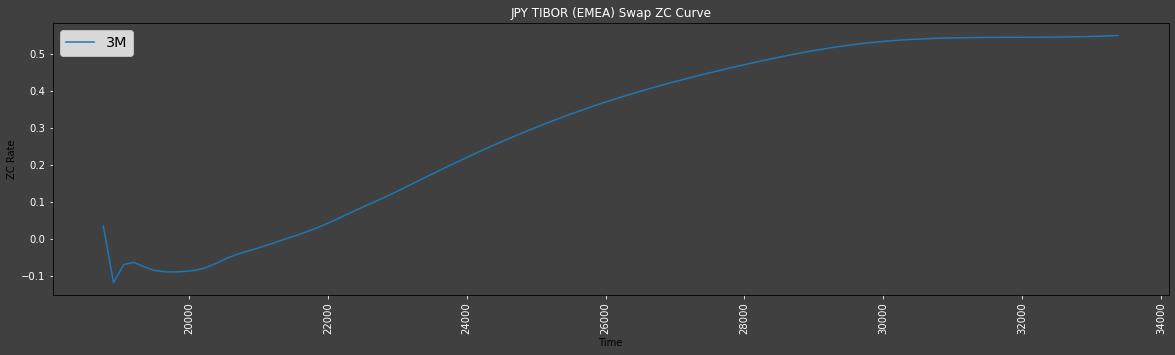

In [10]:
plot_zc_curves(response.data.raw['data'][0], ['3M'])

#### Getting our Curve points into a Dataframe

In [11]:
pd.DataFrame(response.data.raw['data'][0]["curves"]["3M"]["curvePoints"])

,discountFactor,endDate,ratePercent,startDate,tenor,instruments
0,1.000000,2021-05-19,0.033464,2021-05-19,0D,NaN
1,0.999998,2021-05-21,0.033464,2021-05-19,2D,NaN
2,0.999992,2021-05-28,0.033464,2021-05-19,1W,[{'instrumentCode': 'ZTIJPY1WD='}]
3,0.999872,2021-06-21,0.141175,2021-05-19,1M,[{'instrumentCode': 'ZTIJPY1MD='}]
4,1.000168,2021-08-23,-0.063818,2021-05-19,3M,[{'instrumentCode': 'ZTIJPY3MD='}]
5,1.000332,2021-11-22,-0.064802,2021-05-19,6M,[{'instrumentCode': 'JPAM3T6M=TRDT'}]
6,1.000506,2022-02-21,-0.066409,2021-05-19,9M,[{'instrumentCode': 'JPAM3T9M=TRDT'}]
7,1.000674,2022-05-23,-0.066590,2021-05-19,1Y,[{'instrumentCode': 'JPAM3T1Y=TRDT'}]
8,1.001104,2022-11-21,-0.073094,2021-05-19,1Y6M,[{'instrumentCode': 'JPAM3T18M=TRDT'}]
9,1.001726,2023-05-22,-0.085822,2021-05-19,2Y,[{'instrumentCode': 'JPAM3T2Y=TRDT'}]


Note the final column, which shows the **Instrument** that was used for the bootstrapping when generating the individual curve points

#### Requesting Curve using Parameters 
As an alternative to using the Curve ID, I can also request a curve using Curve Parameters and Definition values.  
Some of the key Parameters here are:  
* Valuation Date
* InterpolationMode e.g. CubicSpline, CubicDiscount, Linear etc
* Day Count Basis e.g.
  - Actual, AFD, ISDA, 360, 365...
  - 30_360, 30_360_US, 30_360_German...
  - 30_365, 30_365_US, 30_365_German...  
  
One thing to be aware of here is that if we had more than one EUR curve, I would need to specify sufficient **Definition** parameters to uniquely identify the curve I want.  
So, for example if we had two 'EURIBOR' based curves, I would need to specify the full **name** as well (or other unique definition parameter) - but as we currently only have one, I can just specify the **indexName** as I have done below.

In [12]:
request_body={
    "universe": [
    {
        "curveParameters": {
            "valuationDate":"2020-06-30",
            "interpolationMode": "CubicSpline",
            "priceSide": "Mid",
            "interestCalculationMethod": "Dcb_Actual_Actual",
            "extrapolationMode": "Linear"
        },
        
        "curveDefinition": {
            "currency": "EUR",
            "indexName":"EURIBOR",
            "discountingTenor": "OIS",
            "indexTenors":["6M"]
        }
    }],
    
    "outputs":["Constituents"]
}

response = zcCurve_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = request_body
)

print(json.dumps(response.data.raw, indent=2))

{
  "data": [
    {
      "curveParameters": {
        "extrapolationMode": "Linear",
        "interpolationMode": "CubicSpline",
        "interestCalculationMethod": "Dcb_Actual_Actual",
        "priceSide": "Mid",
        "calendarAdjustment": "Calendar",
        "calendars": [
          "EMU_FI"
        ],
        "compoundingType": "Compounded",
        "useMultiDimensionalSolver": true,
        "useConvexityAdjustment": true,
        "useSteps": false,
        "convexityAdjustment": {
          "meanReversionPercent": -1.3584,
          "volatilityPercent": 0.474
        },
        "valuationDate": "2020-06-30",
        "ignoreExistingDefinition": false
      },
      "curveDefinition": {
        "availableTenors": [
          "OIS",
          "1M",
          "3M",
          "6M",
          "1Y"
        ],
        "currency": "EUR",
        "mainConstituentAssetClass": "Swap",
        "riskType": "InterestRate",
        "indexName": "EURIBOR",
        "source": "Refinitiv",
      

As you can see from the above response, it contains the following:

1. The full set of Curve Parameters and Definition used to produce the curve
2. Curve point data for each available Tenor
3. List of Constituents

#### Plot the data

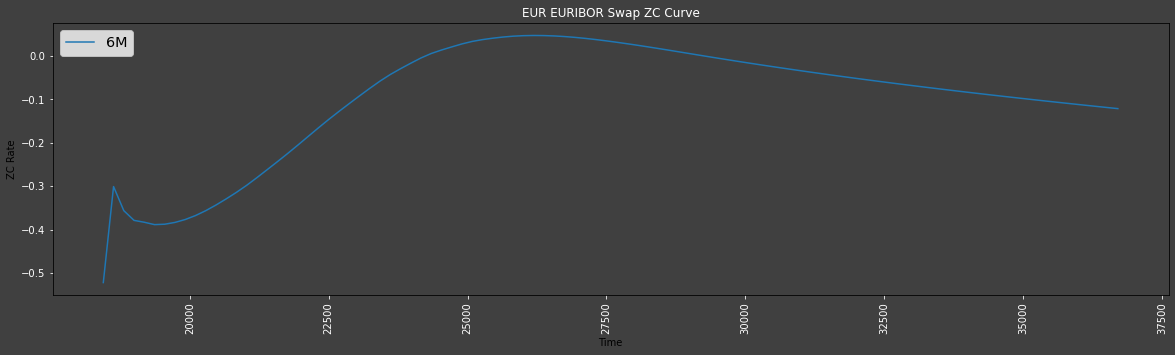

In [13]:
plot_zc_curves(response.data.raw['data'][0], ['6M'])

If a particular Currency e.g. SEK, has only one curve available, the **indexName** attribute can be omitted.  
Likewise, there are several other parameters where you can override the default to control the results.

### Specifying the curve output Tenors
##### Generating a forward curve built with the market date of Jan 30th, 2021
As well as the Index Tenor, we provide the Start Tenor and the Tenors we wish to generate the Forward Curve for and use the **Forward Curves Endpoint** we defined towards the start of the article.

In [14]:
request_body={
    "universe":[
        {
            "curveDefinition": {
                "currency": "JPY",
                "indexName": "LIBOR",
               "discountingTenor": "1M"
              },
            
            "curveParameters":{
            "valuationDate":"2021-01-30"
            },

            "forwardCurveDefinitions": [
                  {
                      "indexTenor": "1M",
                      "forwardStartTenor":"2D",
                      "forwardCurveTenors": [
                          "0M","1M","2M","3M","4M","5M","6M","7M","8M","9M","10M","11M","12M","13M","14M","15M",
                          "16M","17M","18M","19M","20M","21M","22M","23M","24M","25M","26M","27M","28M","29M","30M",
                          "31M","32M","33M","34M","35M","36M","37M","38M","39M","40M","41M","42M","43M","44M","45M",
                          "46M","47M","48M","49M","50M","51M","52M","53M","54M","55M","56M","57M","58M","59M","60M","61M"]
                  }
              ]
        }
    ]
}

response = forward_zcCurve_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = request_body)


print(json.dumps(response.data.raw, indent=2))

{
  "data": [
    {
      "curveParameters": {
        "interestCalculationMethod": "Dcb_Actual_Actual",
        "priceSide": "Mid",
        "calendarAdjustment": "Calendar",
        "calendars": [
          "JAP_FI"
        ],
        "compoundingType": "Compounded",
        "useConvexityAdjustment": true,
        "useSteps": false,
        "valuationDate": "2021-01-30",
        "ignoreExistingDefinition": false
      },
      "curveDefinition": {
        "availableTenors": [
          "6M",
          "OIS",
          "3M",
          "1M"
        ],
        "currency": "JPY",
        "mainConstituentAssetClass": "Swap",
        "riskType": "InterestRate",
        "indexName": "LIBOR",
        "source": "Refinitiv",
        "name": "JPY LIBOR Swap ZC Curve",
        "id": "cbf84acf-5328-4efc-8d23-f476ac495d82",
        "discountingTenor": "1M"
      },
      "forwardCurves": [
        {
          "curvePoints": [
            {
              "discountFactor": 1.000002876383664,
        

#### Get our Curve points into a Dataframe

In [15]:
pd.DataFrame(response.data.raw['data'][0]['forwardCurves'][0]['curvePoints'])

,discountFactor,endDate,ratePercent,startDate,tenor
0,1.000003,2021-02-03,-0.052624,2021-02-01,0M
1,1.000047,2021-03-03,-0.057733,2021-02-01,1M
2,1.000107,2021-04-05,-0.061694,2021-02-01,2M
3,1.000169,2021-05-06,-0.065725,2021-02-01,3M
4,1.000234,2021-06-03,-0.069938,2021-02-01,4M
...,...,...,...,...,...
57,1.005292,2025-11-04,-0.110903,2021-02-01,57M
58,1.005332,2025-12-03,-0.109920,2021-02-01,58M
59,1.005377,2026-01-05,-0.108800,2021-02-01,59M
60,1.005414,2026-02-03,-0.107819,2021-02-01,60M


#### Implied Foreign Currencies / Currency Adjusted ZC Curves
Here we are using the **referenceCurveDefinition** parameter to calculate a JPY curve currency adjusted for the USD using LIBOR i.e. integrate currency basis swap, starting with the USD Libor as the reference curve.

In [16]:
request_body={
    "universe": [
        {
            "curveDefinition": {
                "currency":"JPY",
                "indexName":"LIBOR",
                "discountingTenor": "6M",
                "referenceCurveDefinition": {
                    "currency":"USD",
                    "indexName":"LIBOR",
                    "mainConstituentAssetClass":"Swap",
                    "discountingTenor": "6M",
                }
            }            
        }]
}

response = zcCurve_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = request_body
)


In [17]:
print(json.dumps(response.data.raw, indent=2))

{
  "data": [
    {
      "curveParameters": {
        "extrapolationMode": "None",
        "interpolationMode": "CubicDiscount",
        "interestCalculationMethod": "Dcb_Actual_Actual",
        "priceSide": "Mid",
        "calendarAdjustment": "Calendar",
        "calendars": [
          "JAP_FI"
        ],
        "compoundingType": "Compounded",
        "useMultiDimensionalSolver": true,
        "useConvexityAdjustment": true,
        "useSteps": false,
        "convexityAdjustment": {
          "meanReversionPercent": -6.9606,
          "volatilityPercent": 0.142
        },
        "valuationDate": "2021-05-19",
        "ignoreExistingDefinition": false,
        "referenceCurveParameters": {
          "priceSide": "Mid",
          "calendarAdjustment": "Calendar",
          "compoundingType": "Compounded",
          "useMultiDimensionalSolver": true,
          "useConvexityAdjustment": true,
          "useSteps": false,
          "convexityAdjustment": {
            "meanReversion

In [18]:
pd.DataFrame(response.data.raw['data'][0]['curves']['6M']['curvePoints'])

,discountFactor,endDate,ratePercent,startDate,tenor,instruments
0,1.000000,2021-05-19,-0.037043,2021-05-19,0D,NaN
1,1.000005,2021-05-24,-0.037043,2021-05-19,5D,NaN
2,1.000022,2021-05-28,-0.090947,2021-05-19,1W,NaN
3,1.000126,2021-06-21,-0.139722,2021-05-19,1M,NaN
4,1.000294,2021-07-21,-0.170013,2021-05-19,2M,NaN
5,1.000364,2021-08-23,-0.138219,2021-05-19,3M,NaN
6,1.000363,2021-11-22,-0.070822,2021-05-19,6M,NaN
7,1.000996,2022-02-22,-0.130201,2021-05-19,9M,NaN
8,1.001230,2022-05-19,-0.122854,2021-05-19,1Y,[{'instrumentCode': 'JPYCBS1Y=TTKL'}]
9,1.013862,2023-05-19,-0.685953,2021-05-19,2Y,[{'instrumentCode': 'JPYCBS2Y=COBA'}]


#### Alternative Discounting Tenor
Here we are requesting the GBP 6M LIBOR Curve by it's ID, collateralized with the USD 6M LIBOR curve 

In [19]:
request_body={
    "universe": [
        {
            "curveDefinition": {
                "id": "69348bb7-d0b3-49b3-b2b2-782ab4ad29f8", #GBP 6M LIBOR.
                #"indexTenors":["6M"],
                "discountingTenor":"6M",
                "referenceCurveDefinition": {
                    "id": "1ef0692f-1cde-4b71-bad7-e39198633e0e", #USD 6M LIBOR.
                    "discountingTenor":"6M"
                }

            }
            
        }],
    "outputs": ["DetailedCurvePoint"]
}

response = zcCurve_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = request_body
)

print(json.dumps(response.data.raw, indent=2))
curves = response.data.raw['data'][0]["curves"]["6M"]["curvePoints"]

{
  "data": [
    {
      "curveParameters": {
        "extrapolationMode": "None",
        "interpolationMode": "CubicDiscount",
        "interestCalculationMethod": "Dcb_Actual_Actual",
        "priceSide": "Mid",
        "calendarAdjustment": "Calendar",
        "calendars": [
          "UKG_FI"
        ],
        "compoundingType": "Compounded",
        "useMultiDimensionalSolver": true,
        "useConvexityAdjustment": true,
        "useSteps": false,
        "convexityAdjustment": {
          "meanReversionPercent": -0.7192,
          "volatilityPercent": 0.656
        },
        "valuationDate": "2021-05-19",
        "ignoreExistingDefinition": false,
        "referenceCurveParameters": {
          "priceSide": "Mid",
          "calendarAdjustment": "Calendar",
          "compoundingType": "Compounded",
          "useMultiDimensionalSolver": true,
          "useConvexityAdjustment": true,
          "useSteps": false,
          "convexityAdjustment": {
            "meanReversion

### Taking collateral currency into account
Similarly, we can use a Pivot Curve - so for example, instead of going directly from EUR to JPY, we are going via USD.

In [20]:
request_body={
    "universe": [
        {
            "curveDefinition": {
                "currency":"JPY",
                "indexName":"LIBOR",
                "discountingTenor": "OIS",
                "pivotCurveDefinition":{
                    "currency":"USD",
                    "indexName":"LIBOR",
                    "mainConstituentAssetClass":"Swap",
                    "discountingTenor": "OIS"
                },
                "referenceCurveDefinition": {
                    "currency":"EUR",
                    "indexName":"ESTR",
                    "discountingTenor": "OIS"
                }
            }           
        }]
}

response = zcCurve_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = request_body
)

In [21]:
print(json.dumps(response.data.raw, indent=2))

{
  "data": [
    {
      "curveParameters": {
        "extrapolationMode": "None",
        "interpolationMode": "CubicDiscount",
        "interestCalculationMethod": "Dcb_Actual_Actual",
        "priceSide": "Mid",
        "calendarAdjustment": "Calendar",
        "calendars": [
          "JAP_FI"
        ],
        "compoundingType": "Compounded",
        "useMultiDimensionalSolver": true,
        "useConvexityAdjustment": true,
        "useSteps": false,
        "convexityAdjustment": {
          "meanReversionPercent": -6.9606,
          "volatilityPercent": 0.142
        },
        "valuationDate": "2021-05-19",
        "ignoreExistingDefinition": false,
        "pivotCurveParameters": {
          "priceSide": "Mid",
          "calendarAdjustment": "Calendar",
          "compoundingType": "Compounded",
          "useConvexityAdjustment": true,
          "useSteps": false,
          "convexityAdjustment": {
            "meanReversionPercent": 1.295,
            "volatilityPercent":

In [22]:
pd.DataFrame(response.data.raw['data'][0]["curves"]["OIS"]["curvePoints"])

,discountFactor,endDate,ratePercent,startDate,tenor
0,1.000000,2021-05-19,-0.318461,2021-05-19,0D
1,1.000044,2021-05-24,-0.318461,2021-05-19,5D
2,1.000061,2021-05-28,-0.247789,2021-05-19,1W
3,1.000161,2021-06-21,-0.177424,2021-05-19,1M
4,1.000290,2021-07-21,-0.168051,2021-05-19,2M
5,1.000443,2021-08-23,-0.168357,2021-05-19,3M
6,1.000934,2021-11-22,-0.182026,2021-05-19,6M
7,1.001674,2022-02-22,-0.218582,2021-05-19,9M
8,1.002216,2022-05-19,-0.221105,2021-05-19,1Y
9,1.015546,2023-05-19,-0.768365,2021-05-19,2Y


### User defined ZC Curves
So far I have requested Refinitiv defined Curves and how you can use parameters to customise the generated output.
However, one of the other great features of the Zero Coupons APIs is that you can define your own ZC Curves by specifying your own constituents.   
You will have noted that when I requested a Refinitiv defined curve, the response included the constituents used to generate the curve. So, if required you can take one of our existing curves and modify the constituents and parameter to generate your own custom curve.  


In [23]:
user_defined_zc_request_body = {
 "universe": [
    {
      "curveParameters": {
        "ignoreExistingDefinition": True,
        "valuationDate": "2021-02-23"
      },
      "curveDefinition": {
        "currency": "EUR",
        "discountingTenor": "OIS"
      },
      "constituents": {
        "interestRateInstruments": {
          "EUR": {
            "deposits": [
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUROND=",
                  "template": "EUR",
                  "tenor": "ON"
                },
                "basis": [
                  "6M",
                  "1Y",
                  "3M",
                  "OIS",
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURTND=",
                  "template": "EUR",
                  "tenor": "TN"
                },
                "basis": [
                  "6M",
                  "1Y",
                  "3M",
                  "OIS",
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURIBOR1YD=",
                  "template": "EUR",
                  "tenor": "1Y"
                },
                "basis": [
                  "1Y"
                ]
              }
            ],
            "fras": [
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR4X10F=SMKR",
                  "template": "EURFRA",
                  "tenor": "4X10"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR0X1F=SMKR",
                  "template": "EURFRA",
                  "tenor": "0X1"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR3X9F=SMKR",
                  "template": "EURFRA",
                  "tenor": "3X9"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR5X11F=SMKR",
                  "template": "EURFRA",
                  "tenor": "5X11"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR0X6F=SMKR",
                  "template": "EURFRA",
                  "tenor": "0X6"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR12X18F=SMKR",
                  "template": "EURFRA",
                  "tenor": "12X18"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1X7F=SMKR",
                  "template": "EURFRA",
                  "tenor": "1X7"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR0X3F=SMKR",
                  "template": "EURFRA",
                  "tenor": "0X3"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR6X12F=SMKR",
                  "template": "EURFRA",
                  "tenor": "6X12"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR2X8F=SMKR",
                  "template": "EURFRA",
                  "tenor": "2X8"
                },
                "basis": [
                  "6M"
                ]
              }
            ],
            "futures": [
              {
                "basis": [
                  "3M"
                ],
                "instrumentDefinition": {
                  "instrumentCode": "FEIcm8",
                  "template": "FEI"
                }
              },
              {
                "basis": [
                  "3M"
                ],
                "instrumentDefinition": {
                  "instrumentCode": "FEIcm1",
                  "template": "FEI"
                }
              },
              {
                "basis": [
                  "3M"
                ],
                "instrumentDefinition": {
                  "instrumentCode": "FEIcm7",
                  "template": "FEI"
                }
              },
              {
                "basis": [
                  "3M"
                ],
                "instrumentDefinition": {
                  "instrumentCode": "FEIcm4",
                  "template": "FEI"
                }
              },
              {
                "basis": [
                  "3M"
                ],
                "instrumentDefinition": {
                  "instrumentCode": "FEIcm2",
                  "template": "FEI"
                }
              },
              {
                "basis": [
                  "3M"
                ],
                "instrumentDefinition": {
                  "instrumentCode": "FEIcm3",
                  "template": "FEI"
                }
              },
              {
                "basis": [
                  "3M"
                ],
                "instrumentDefinition": {
                  "instrumentCode": "FEIcm6",
                  "template": "FEI"
                }
              },
              {
                "basis": [
                  "3M"
                ],
                "instrumentDefinition": {
                  "instrumentCode": "FEIcm5",
                  "template": "FEI"
                }
              }
            ],
            "interestRateSwaps": [
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E14Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "14Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E8Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "8Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E3Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "3Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E12Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "12Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAM1E3M=TWEB",
                  "template": "EUR_AM1E",
                  "tenor": "3M"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E2Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "2Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E13Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "13Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E7Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "7Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E50Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "50Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E13Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "13Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAM1E4M=TWEB",
                  "template": "EUR_AM1E",
                  "tenor": "4M"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E25Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "25Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAM1E2M=ICAP",
                  "template": "EUR_AM1E",
                  "tenor": "2M"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAM1E1Y=TWEB",
                  "template": "EUR_AM1E",
                  "tenor": "12M"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E2Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "2Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E12Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "12Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E5Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "5Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E14Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "14Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAM1E15M=TWEB",
                  "template": "EUR_AM1E",
                  "tenor": "15M"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E40Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "40Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E25Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "25Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAM1E5M=TWEB",
                  "template": "EUR_AM1E",
                  "tenor": "5M"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E5Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "5Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E15Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "15Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E8Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "8Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E19Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "19Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E11Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "11Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAM1E18M=TWEB",
                  "template": "EUR_AM1E",
                  "tenor": "18M"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAM1E10M=TWEB",
                  "template": "EUR_AM1E",
                  "tenor": "10M"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E18Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "18Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E40Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "40Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E4Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "4Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E10Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "10Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E7Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "7Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E16Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "16Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E30Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "30Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E20Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "20Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAM1E7M=TWEB",
                  "template": "EUR_AM1E",
                  "tenor": "7M"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E17Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "17Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E3Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "3Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E6Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "6Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E17Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "17Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E50Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "50Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E20Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "20Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAM1E8M=TWEB",
                  "template": "EUR_AM1E",
                  "tenor": "8M"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E16Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "16Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E6Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "6Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E9Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "9Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E18Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "18Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E10Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "10Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAM1E11M=TWEB",
                  "template": "EUR_AM1E",
                  "tenor": "11M"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAM1E9M=TWEB",
                  "template": "EUR_AM1E",
                  "tenor": "9M"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E19Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "19Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E11Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "11Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E9Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "9Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E4Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "4Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB6E15Y=TWEB",
                  "template": "EUR_AB6E",
                  "tenor": "15Y"
                },
                "basis": [
                  "6M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAB3E30Y=TWEB",
                  "template": "EUR_AB3E",
                  "tenor": "30Y"
                },
                "basis": [
                  "3M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EURAM1E6M=TWEB",
                  "template": "EUR_AM1E",
                  "tenor": "6M"
                },
                "basis": [
                  "1M"
                ]
              }
            ],
            "overnightIndexSwaps": [
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON11Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "11Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON9M=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "9M"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON3Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "3Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON1M=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "1M"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON10M=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "10M"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON12Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "12Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON18M=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "18M"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON8M=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "8M"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON2Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "2Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON19M=TTKL",
                  "template": "OIS_EONIA",
                  "tenor": "19M"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON20Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "20Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON15M=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "15M"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON9Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "9Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON3M=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "3M"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON10Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "10Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON20M=TTKL",
                  "template": "OIS_EONIA",
                  "tenor": "20M"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON6M=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "6M"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON4Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "4Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON40Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "40Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON50Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "50Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON15Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "15Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON7Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "7Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON5M=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "5M"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON2W=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "2W"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON25Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "25Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREONSW=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "SW"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON6Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "6Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON1Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "12M"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON4M=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "4M"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON3W=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "3W"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON11M=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "11M"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON5Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "5Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON7M=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "7M"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON30Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "30Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON21M=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "21M"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON8Y=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "8Y"
                },
                "basis": [
                  "OIS"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUREON2M=ICAP",
                  "template": "OIS_EONIA",
                  "tenor": "2M"
                },
                "basis": [
                  "OIS"
                ]
              }
            ],
            "tenorBasisSwaps": [
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR6E12E5Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:1 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:2 PDELAY:0",
                  "tenor": "5Y"
                },
                "basis": [
                  "1Y"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR6E12E12Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:1 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:2 PDELAY:0",
                  "tenor": "12Y"
                },
                "basis": [
                  "1Y"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E2Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "2Y"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR6E12E4Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:1 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:2 PDELAY:0",
                  "tenor": "4Y"
                },
                "basis": [
                  "1Y"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E9Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "9Y"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E25Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "25Y"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR6E12E7Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:1 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:2 PDELAY:0",
                  "tenor": "7Y"
                },
                "basis": [
                  "1Y"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E4Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "4Y"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR6E12E25Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:1 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:2 PDELAY:0",
                  "tenor": "25Y"
                },
                "basis": [
                  "1Y"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E50Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "50Y"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E15Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "15Y"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR6E12E30Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:1 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:2 PDELAY:0",
                  "tenor": "30Y"
                },
                "basis": [
                  "1Y"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR6E12E2Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:1 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:2 PDELAY:0",
                  "tenor": "2Y"
                },
                "basis": [
                  "1Y"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E7Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "7Y"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR6E12E11Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:1 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:2 PDELAY:0",
                  "tenor": "11Y"
                },
                "basis": [
                  "1Y"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E12Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "12Y"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR6E12E9Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:1 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:2 PDELAY:0",
                  "tenor": "9Y"
                },
                "basis": [
                  "1Y"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E30Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "30Y"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E6Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "6Y"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E20Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "20Y"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E40Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "40Y"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR6E12E8Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:1 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:2 PDELAY:0",
                  "tenor": "8Y"
                },
                "basis": [
                  "1Y"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E5Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "5Y"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR6E12E20Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:1 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:2 PDELAY:0",
                  "tenor": "20Y"
                },
                "basis": [
                  "1Y"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E10Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "10Y"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR6E12E3Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:1 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:2 PDELAY:0",
                  "tenor": "3Y"
                },
                "basis": [
                  "1Y"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E8Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "8Y"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR6E12E10Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:1 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:2 PDELAY:0",
                  "tenor": "10Y"
                },
                "basis": [
                  "1Y"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E11Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "11Y"
                },
                "basis": [
                  "1M"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR6E12E6Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:1 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:2 PDELAY:0",
                  "tenor": "6Y"
                },
                "basis": [
                  "1Y"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR6E12E15Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:1 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:2 PDELAY:0",
                  "tenor": "15Y"
                },
                "basis": [
                  "1Y"
                ]
              },
              {
                "instrumentDefinition": {
                  "instrumentCode": "EUR1E3E3Y=ICAP",
                  "template": "LBOTH CROSS:EUR CLDR:EMU SETTLE:2WD LRECEIVED LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:4 PDELAY:0 LPAID LTYPE:FLOAT CUR:EUR CFADJ:Y CCM:MMA0 DMC:M EMC:S FRQ:12 PDELAY:0",
                  "tenor": "3Y"
                },
                "basis": [
                  "1M"
                ]
              }
            ]
          }
        }
      }
    }
  ],
  "outputs": [
    "DetailedCurvePoint",
    "Constituents"
  ]
}



user_defined_zc_response = zcCurve_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = user_defined_zc_request_body
)

print(json.dumps(user_defined_zc_response.data.raw, indent=2))

{
  "data": [
    {
      "curveParameters": {
        "extrapolationMode": "None",
        "interpolationMode": "CubicDiscount",
        "interestCalculationMethod": "Dcb_Actual_Actual",
        "priceSide": "Mid",
        "calendarAdjustment": "Calendar",
        "calendars": [
          "EMU_FI"
        ],
        "compoundingType": "Compounded",
        "useMultiDimensionalSolver": true,
        "useConvexityAdjustment": true,
        "useSteps": false,
        "convexityAdjustment": {
          "meanReversionPercent": -1.6963,
          "volatilityPercent": 0.443
        },
        "valuationDate": "2021-02-23",
        "ignoreExistingDefinition": true
      },
      "curveDefinition": {
        "availableTenors": [
          "OIS",
          "1M",
          "3M",
          "6M",
          "1Y"
        ],
        "currency": "EUR",
        "discountingTenor": "OIS",
        "indexTenors": [
          "OIS",
          "1M",
          "3M",
          "6M",
          "1Y"
        ]
 

In [24]:
curves = user_defined_zc_response.data.raw['data'][0]["curves"]["3M"]["curvePoints"]
pd.DataFrame(data=curves)

,discountFactor,endDate,ratePercent,startDate,tenor,instruments
0,1.000000,2021-02-23,-0.557610,2021-02-23,0D,NaN
1,1.000015,2021-02-24,-0.557610,2021-02-23,ON,"[{'instrumentCode': 'EUROND=', 'value': -0.55}]"
2,1.000031,2021-02-25,-0.557610,2021-02-23,2D,NaN
3,1.001367,2021-05-25,-0.546581,2021-02-23,NaN,"[{'instrumentCode': 'EUR0X3F=SMKR', 'value': -..."
4,1.001697,2021-06-17,-0.541391,2021-02-23,NaN,"[{'instrumentCode': 'FEIcm1', 'value': 100.5325}]"
5,1.003048,2021-09-16,-0.540408,2021-02-23,NaN,"[{'instrumentCode': 'FEIcm2', 'value': 100.5325}]"
6,1.004387,2021-12-15,-0.540104,2021-02-23,NaN,"[{'instrumentCode': 'FEIcm3', 'value': 100.5325}]"
7,1.005741,2022-03-15,-0.541234,2021-02-23,NaN,"[{'instrumentCode': 'FEIcm4', 'value': 100.5375}]"
8,1.007124,2022-06-16,-0.540611,2021-02-23,NaN,"[{'instrumentCode': 'FEIcm5', 'value': 100.53}]"
9,1.008488,2022-09-15,-0.540721,2021-02-23,NaN,"[{'instrumentCode': 'FEIcm6', 'value': 100.5325}]"


### Financial Contracts API
Whilst the main focus of this article is Zero Coupon, I felt it would be remiss of me to not to briefly mention the related IPA **Financial Contracts API** - which may also of be some interest.   

As with the ZC Curves API, we need to know the endpoint URL:

In [25]:
financial_contract_endpoint = rdp.Endpoint(session, 
            'https://api.refinitiv.com/data/quantitative-analytics/v1/financial-contracts')

#### Interest Rate swap examples
With the above ZC examples, I showed how you could request a particular curve and use the data in your own application.   
However, by using the Financial Contracts API, you can describe an instrument and the apppropriate curves will be fetched behind the scenes.  
So, for example, if I want to request a vanilla AUD Interest Rate Swap based on the BBSW index, I need to:
* specify the fields that I want calculated
* define the instrument to be calculated in terms of the <a href="https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/documentation#ipa-financial-contracts-getting-started" target="_blank">available documented parameters</a>


In [26]:
request_body = {
    
    "fields" : ["InstrumentTag","MarketValueInDealCcy","DirtyPricePercent","FixedRatePercent",\
                "DiscountCurveName","ForwardCurveName","ErrorCode","ErrorMessage"],
    
    "universe" : [
        {
            "instrumentType":"Swap",
            "instrumentDefinition": {
                "instrumentTag":"IRS-EUR EURIBOR 6M - 5Y",
                "startDate":"2020-07-29",
                "tenor":"5Y",
                "legs":[
                {
                    "direction":"Paid",
                    "interestType":"Fixed",
                    "notionalCcy":"EUR",
                    "interestPaymentFrequency":"Annual",
                    "interestCalculationMethod":"Dcb_Actual_365",
                },
                {
                    "direction":"Received",
                    "interestType":"Float",
                    "interestPaymentFrequency":"SemiAnnual",
                    "interestCalculationMethod":"Dcb_Actual_365",
                    "notionalCcy":"EUR",
                    "indexName":"EURIBOR",
                    "indexTenor":"6M",
                }]
            }
        }],
    
    "pricingParameters": {
        "valuationDate": "2020-7-27T00:00:00Z",
    },
        
    "outputs" : ["Data","Headers"],

}

response = financial_contract_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = request_body)

print(json.dumps(response.data.raw, indent=2))

{
  "headers": [
    {
      "type": "String",
      "name": "InstrumentTag"
    },
    {
      "type": "Float",
      "name": "MarketValueInDealCcy"
    },
    {
      "type": "Float",
      "name": "DirtyPricePercent"
    },
    {
      "type": "Float",
      "name": "FixedRatePercent"
    },
    {
      "type": "String",
      "name": "DiscountCurveName"
    },
    {
      "type": "String",
      "name": "ForwardCurveName"
    },
    {
      "type": "String",
      "name": "ErrorCode"
    },
    {
      "type": "String",
      "name": "ErrorMessage"
    }
  ],
  "data": [
    [
      "IRS-EUR EURIBOR 6M - 5Y",
      -18956.4458024112,
      -1.89564458024112,
      -0.374483171441853,
      "EUR - Swap vs 6M Euribor",
      null,
      "",
      ""
    ],
    [
      "IRS-EUR EURIBOR 6M - 5Y",
      -18956.4458024112,
      -1.89564458024112,
      null,
      "EUR - Swap vs 6M Euribor",
      "EUR - Swap vs 6M Euribor",
      "",
      ""
    ]
  ]
}


In [27]:
pd.DataFrame(data=response.data.raw['data'], columns=[h['name'] for h in response.data.raw['headers']])

,InstrumentTag,MarketValueInDealCcy,DirtyPricePercent,FixedRatePercent,DiscountCurveName,ForwardCurveName,ErrorCode,ErrorMessage
0,IRS-EUR EURIBOR 6M - 5Y,-18956.445802,-1.895645,-0.374483,EUR - Swap vs 6M Euribor,None,,
1,IRS-EUR EURIBOR 6M - 5Y,-18956.445802,-1.895645,NaN,EUR - Swap vs 6M Euribor,EUR - Swap vs 6M Euribor,,


As you will note from the 5th & 6th columns, the response provided details of the underlying curves used to calculate the requested Interest Rate Swap.

In [28]:
session.close()

I hope the above has provided a useful insight into the power of the Zero Coupon Curve APIs that form part of the broader Instrument Pricing Analytics APIs umbrella.

If you have any questions, please feel free to post on the <a href="https://community.developers.refinitiv.com/spaces/231/index.html?_ga=2.223690459.1796103815.1621239883-1976906543.1617709333" target="_blank">Refinitiv Developer Community Forums</a> or create a Content support ticket specifically for the **Instrument Pricing Analytics** product on <a href="https://my.refinitiv.com/content/mytr/en/productsupport.html" target="_blank">My.Refinitiv</a>.